# Healthcare-Dataset-Preprocessing

*`Imports`*

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

*`load data`*

In [2]:
# use os to join the current working directory with the file path
FILE_PATH = os.path.join(os.getcwd(), '..', 'data', 'healthcare-dataset-stroke-data.csv')
df = pd.read_csv(FILE_PATH)

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Dataset Description

- The Stroke Prediction Dataset contains information about patients and various health-related attributes.
- The goal is to predict whether a patient is likely to experience a stroke based on these attributes.

### Problem Defination 

- Stroke is one of the leading causes of death and disability. Early prediction of stroke risk can help in taking preventive measures. 
- The aim of this analysis is to build a predictive model that accurately classifies whether a person will experience a stroke based on their medical and demographic data.
- We will start with EDA amd preprocesssing of the dataset in this notebook

### EDA

In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
# modify the column names to be more user-friendly
df.columns = df.columns.str.replace(' ', '_').str.lower().str.strip()

In [6]:
# drop id 
id_series = df['id']           # Save the 'id' column as a separate Series -> may use later in mapping the predictions back to the original data
df.drop(columns=['id'], inplace=True)

In [7]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
# quick check of the data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]         # will handle later 


bmi    201
dtype: int64

In [10]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

In [11]:
# stats for numerical columns
df.describe(include='number').T
# max far from 75%

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [12]:
# stats for categorical columns
df.describe(include='object').T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


In [13]:
# ranges of the data and possible values for categorical columns

for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].unique()}")
    else:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")

gender: ['Male' 'Female' 'Other']
age: min=0.08, max=82.0
hypertension: min=0, max=1
heart_disease: min=0, max=1
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type: ['Urban' 'Rural']
avg_glucose_level: min=55.12, max=271.74
bmi: min=10.3, max=97.6
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke: min=0, max=1


In [14]:
# Display all duplicate rows
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))
# Display the duplicate rows if exists
if len(duplicates) > 0:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows: 0


In [15]:
# Displaying mode, median, and mean for all numeric columns
for col in df.select_dtypes(include='number').columns:
    mode = df[col].mode()[0] if not df[col].mode().empty else 'No mode'
    median = df[col].median()
    mean = df[col].mean()
    print(f"Column: {col}\nMode: {mode}\nMedian: {median}\nMean: {mean}\n")


Column: age
Mode: 78.0
Median: 45.0
Mean: 43.226614481409

Column: hypertension
Mode: 0
Median: 0.0
Mean: 0.0974559686888454

Column: heart_disease
Mode: 0
Median: 0.0
Mean: 0.05401174168297456

Column: avg_glucose_level
Mode: 93.88
Median: 91.88499999999999
Mean: 106.1476771037182

Column: bmi
Mode: 28.7
Median: 28.1
Mean: 28.893236911794666

Column: stroke
Mode: 0
Median: 0.0
Mean: 0.0487279843444227



Text(0.5, 1.0, 'Distribution of Stroke Cases')

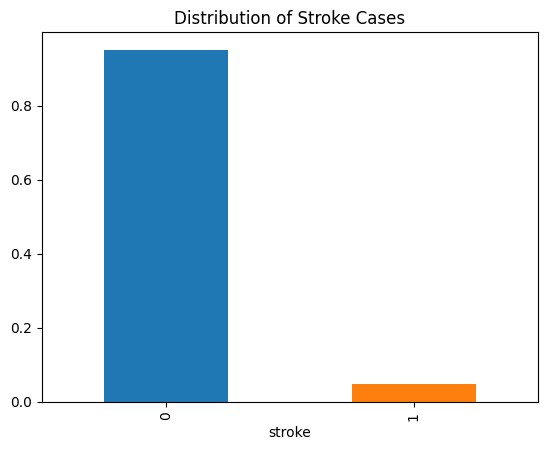

In [16]:
# Check the distribution of the target variable
df['stroke'].value_counts(normalize=True).plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Stroke Cases')


# stroke=0: No stroke, stroke=1: Stroke
# stroke=1 is the positive class (required for prediction)

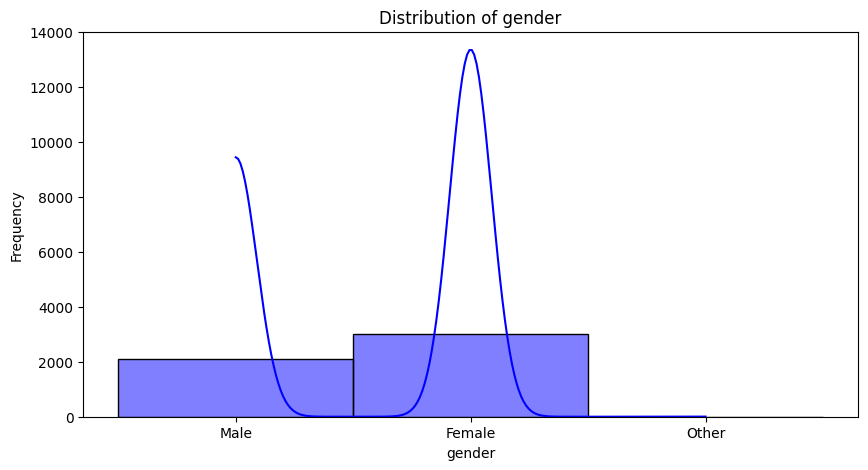

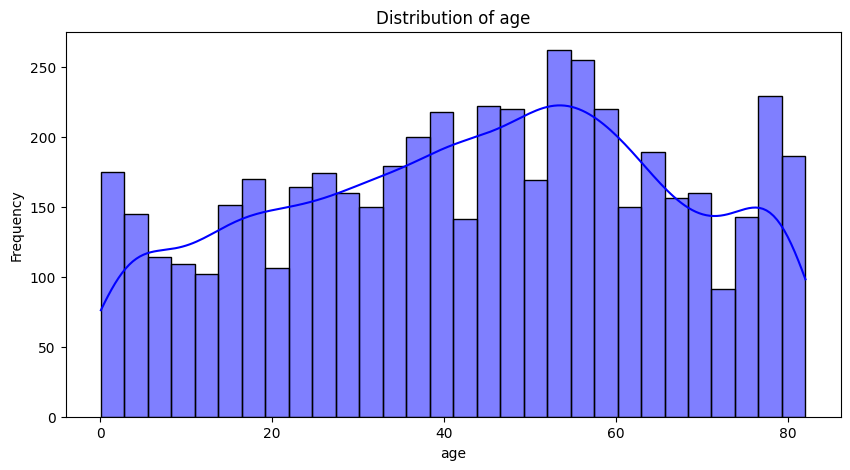

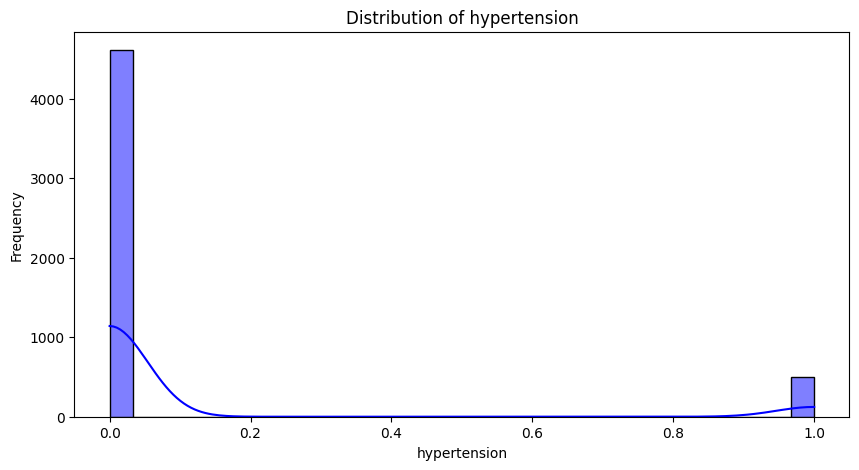

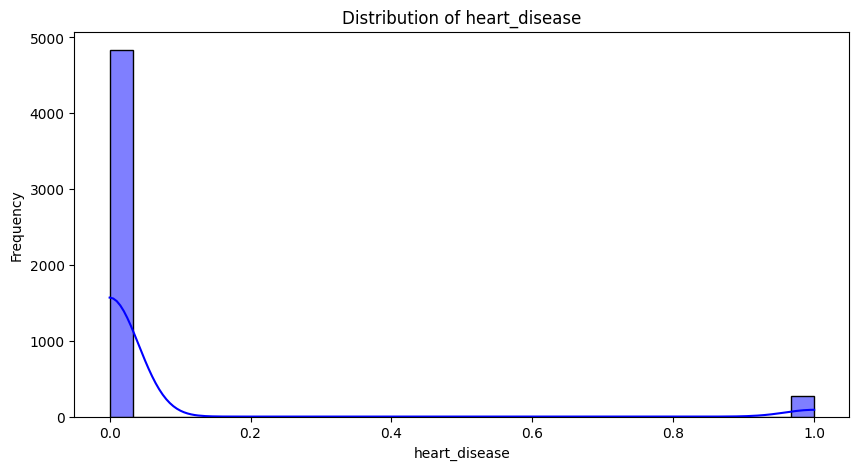

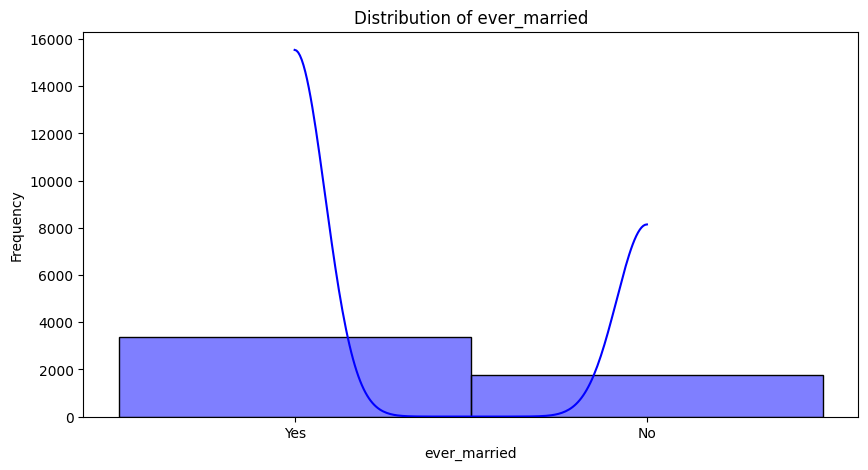

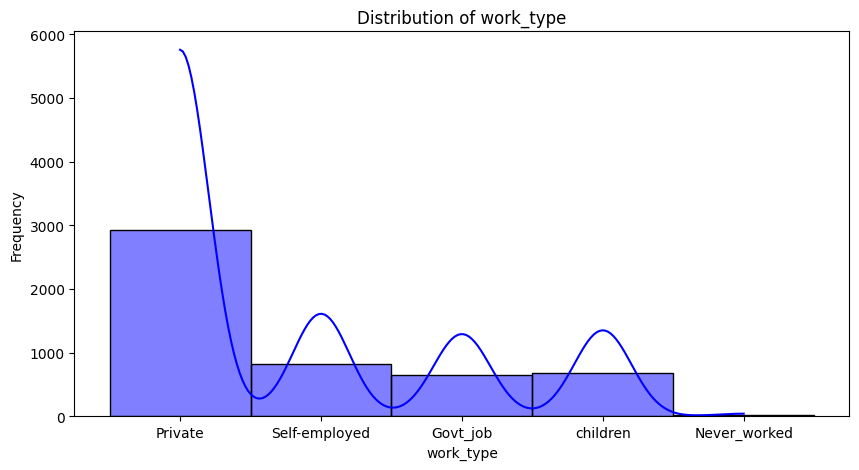

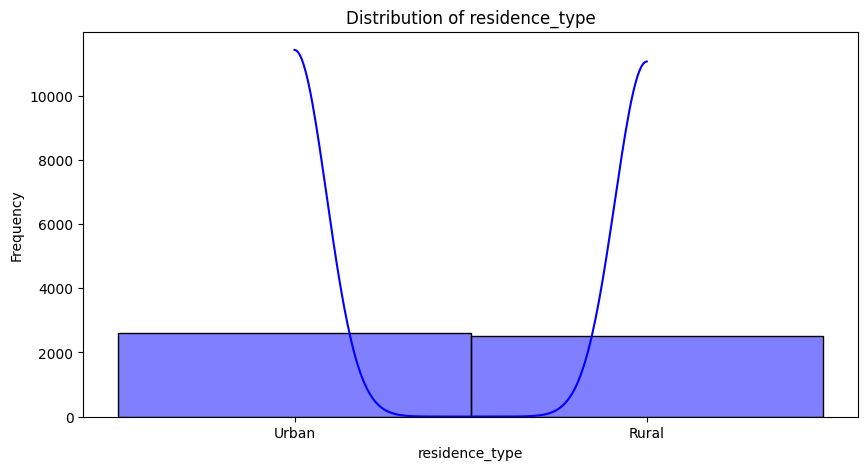

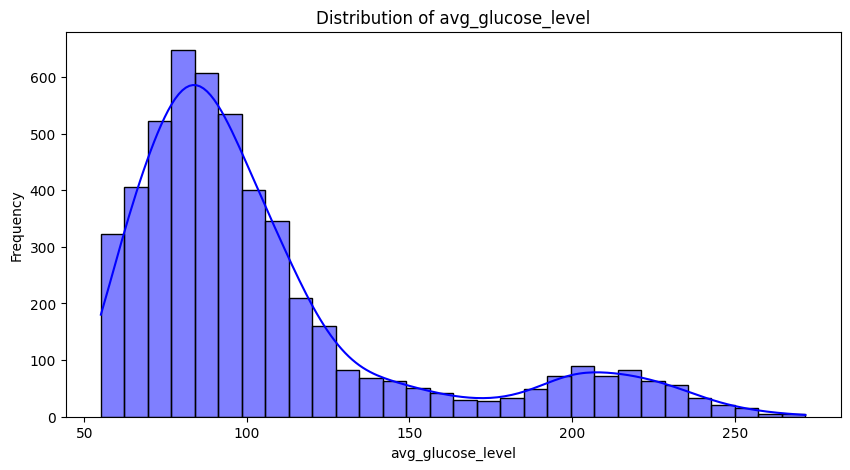

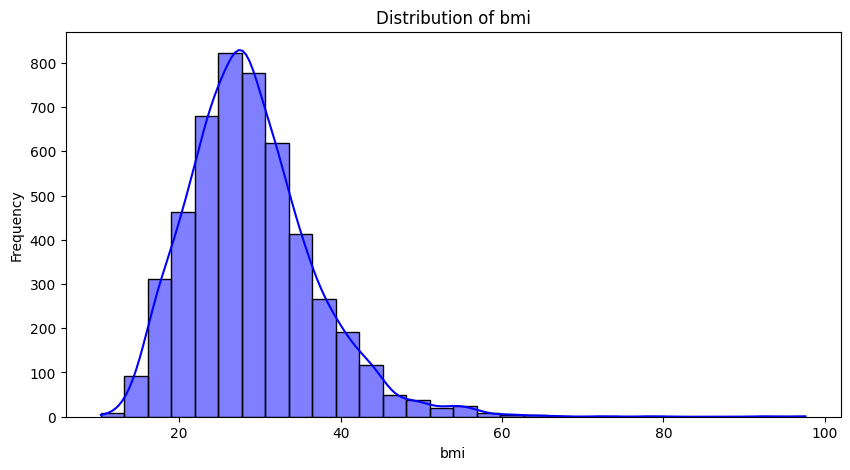

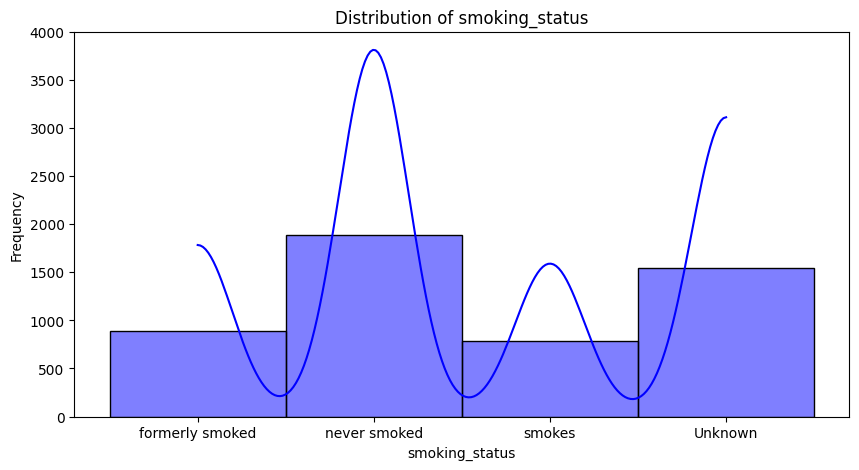

In [17]:
# features distribution alone

for col in df.columns:
    if col != 'stroke':
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()


*`Bivariate Analysis`*

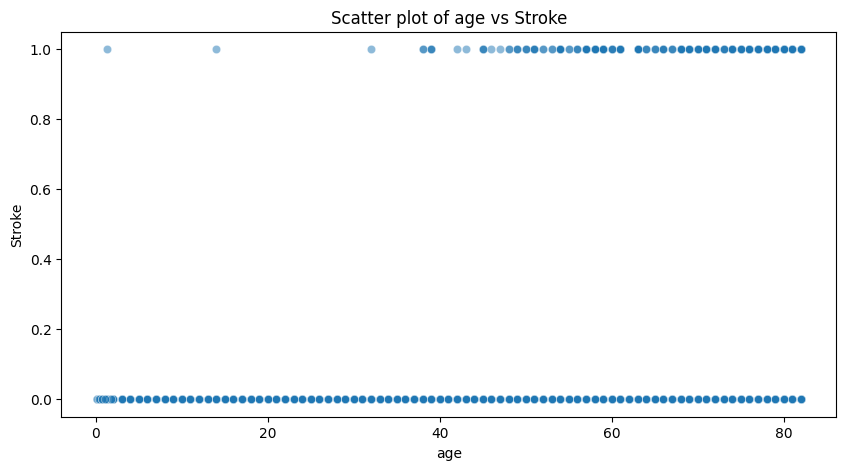

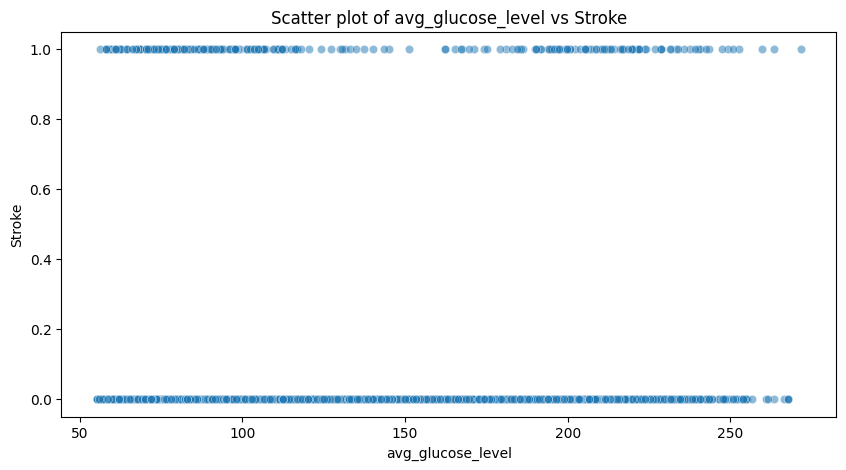

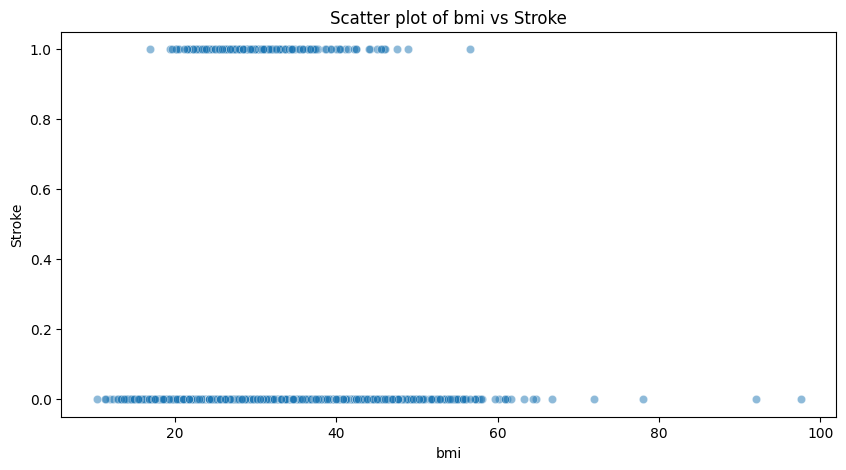

In [18]:
# scatter plots(features vs target)
for select in [df[['age', 'avg_glucose_level', 'bmi']]]:
    for col in select.columns:
        if col != 'stroke':
            plt.figure(figsize=(10, 5))
            sns.scatterplot(data=df, x=col, y='stroke', alpha=0.5)
            plt.title(f'Scatter plot of {col} vs Stroke')
            plt.xlabel(col)
            plt.ylabel('Stroke')
            plt.show()

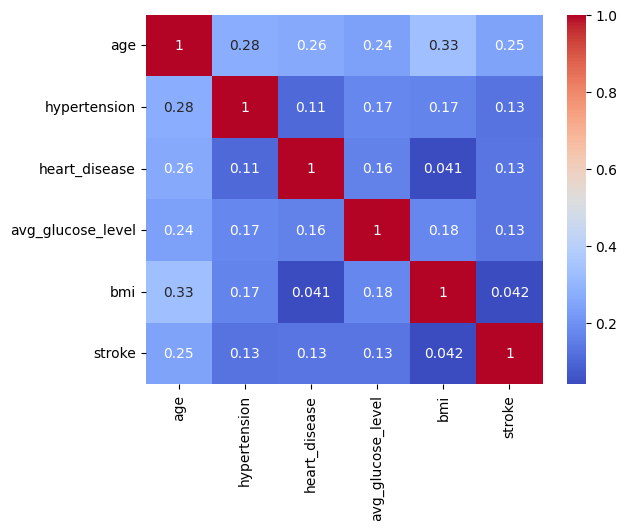

In [19]:
# correlation matrix for numerical features
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

`Outliers`

In [20]:
numerical_df = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']]

outliers_iqr = pd.DataFrame(False, index=numerical_df.index, columns=numerical_df.columns)

for col in numerical_df:
    Q1, Q3 = np.percentile(numerical_df[col].dropna(), [25, 75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers_iqr[col] = (numerical_df[col] < lower) | (numerical_df[col] > upper)

print("Outliers per column (IQR):")
print(outliers_iqr.sum())
# ratio of outliers
print("Outlier ratio per column (IQR):")
print(outliers_iqr.mean())
# ratio from all
print("Overall outlier ratio (IQR):")
print(outliers_iqr.values.mean())

Outliers per column (IQR):
age                    0
hypertension         498
heart_disease        276
avg_glucose_level    627
bmi                  110
dtype: int64
Outlier ratio per column (IQR):
age                  0.000000
hypertension         0.097456
heart_disease        0.054012
avg_glucose_level    0.122701
bmi                  0.021526
dtype: float64
Overall outlier ratio (IQR):
0.05913894324853229


C:\Users\laphouse\AppData\Local\Temp\ipykernel_15192\3181369415.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(numerical_df.values, labels=numerical_df.columns)


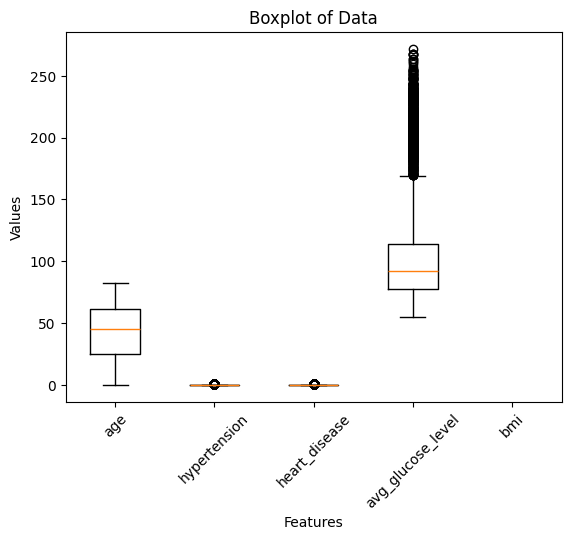

In [21]:
# use boxplot to visualize outliers
plt.boxplot(numerical_df.values, labels=numerical_df.columns)
plt.title("Boxplot of Data")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

In [22]:
# z-score 
z_scores = zscore(numerical_df)
threshold = 3  # confidence is 99.7% (±3 standard deviations)
outliers_z = numerical_df[np.abs(z_scores) > threshold]
print("Z-score Outliers:")
print(outliers_z.sum())

Z-score Outliers:
age                      0.00
hypertension           498.00
heart_disease          276.00
avg_glucose_level    12336.88
bmi                      0.00
dtype: float64


### Preprocessing

*`Drop id`* done

In [23]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


*`Encoding`*

In [24]:
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
columns = ['gender', 'ever_married', 'work_type', 'smoking_status', 'residence_type']  

# Dictionary to store encoders(use for decoding later) and mappings
label_encoders = {}
mappings = {}

# Encoding and creating mappings in a single loop
for col in columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    label_encoders[col] = encoder

    # Creating a dictionary of original: encoded pairs
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    mappings[col] = mapping

In [25]:
# chech after encoding
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [26]:
# mapping the encoded values back to original values
print("\nOriginal to Encoded Mappings:")
for col, mapping in mappings.items():
    print(f"{col}: {mapping}")


Original to Encoded Mappings:
gender: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
ever_married: {'No': np.int64(0), 'Yes': np.int64(1)}
work_type: {'Govt_job': np.int64(0), 'Never_worked': np.int64(1), 'Private': np.int64(2), 'Self-employed': np.int64(3), 'children': np.int64(4)}
smoking_status: {'Unknown': np.int64(0), 'formerly smoked': np.int64(1), 'never smoked': np.int64(2), 'smokes': np.int64(3)}
residence_type: {'Rural': np.int64(0), 'Urban': np.int64(1)}


*`handle missing values`*

In [27]:
# Check the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
missing_percentage[missing_percentage > 0]  # Display columns with missing value

bmi    3.933464
dtype: float64

outliers handling firstly,impute missing values at the end 

In [28]:
# impute missing values using k-nearest neighbors
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors based on your data
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)    # in-place 

In [29]:
# Check if there are any missing values left after imputation

missing_values_after_imputation = df.isnull().sum()
missing_values_after_imputation[missing_values_after_imputation > 0] 

Series([], dtype: int64)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   float64
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   float64
 5   work_type          5110 non-null   float64
 6   residence_type     5110 non-null   float64
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   float64
 10  stroke             5110 non-null   float64
dtypes: float64(11)
memory usage: 439.3 KB


*`Scaling`*

In [31]:
#check if scaling is needed 
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].unique()}")
    else:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")

gender: min=0.0, max=2.0
age: min=0.08, max=82.0
hypertension: min=0.0, max=1.0
heart_disease: min=0.0, max=1.0
ever_married: min=0.0, max=1.0
work_type: min=0.0, max=4.0
residence_type: min=0.0, max=1.0
avg_glucose_level: min=55.12, max=271.74
bmi: min=10.3, max=97.6
smoking_status: min=0.0, max=3.0
stroke: min=0.0, max=1.0


In [32]:
# standarization for logestic regression later

scaler = StandardScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])


In [33]:
# check the scaled values
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,1.051434,0.0,1.0,1.0,2.0,1.0,2.706375,0.985740,1.0,1.0
1,0.0,0.786070,0.0,0.0,1.0,3.0,0.0,2.121559,0.607142,2.0,1.0
2,1.0,1.626390,0.0,1.0,1.0,2.0,0.0,-0.005028,0.457763,2.0,1.0
3,0.0,0.255342,0.0,0.0,1.0,2.0,1.0,1.437358,0.702435,3.0,1.0
4,0.0,1.582163,1.0,0.0,1.0,3.0,0.0,1.501184,-0.636825,2.0,1.0


*`check on gender`*

In [34]:
# Filter rows where gender is 2
filtered_df = df[df['gender'] == 2]

# Count occurrences of stroke = 1 and stroke = 0
stroke_1_count = (filtered_df['stroke'] == 1).sum()
stroke_0_count = (filtered_df['stroke'] == 0).sum()

print(f"Number of rows where gender is 2 and stroke = 1: {stroke_1_count}")
print(f"Number of rows where gender is 2 and stroke = 0: {stroke_0_count}")



Number of rows where gender is 2 and stroke = 1: 0
Number of rows where gender is 2 and stroke = 0: 1


In [35]:
# only 1 row with gender=2(other), so drop this column

df = df.drop(filtered_df.index, axis=0)  # Drop the rows where


In [36]:
# now it's binary feature
# check gender possible values  

print(df['gender'].unique())


[1. 0.]


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   float64
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   float64
 3   heart_disease      5109 non-null   float64
 4   ever_married       5109 non-null   float64
 5   work_type          5109 non-null   float64
 6   residence_type     5109 non-null   float64
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   float64
 10  stroke             5109 non-null   float64
dtypes: float64(11)
memory usage: 479.0 KB


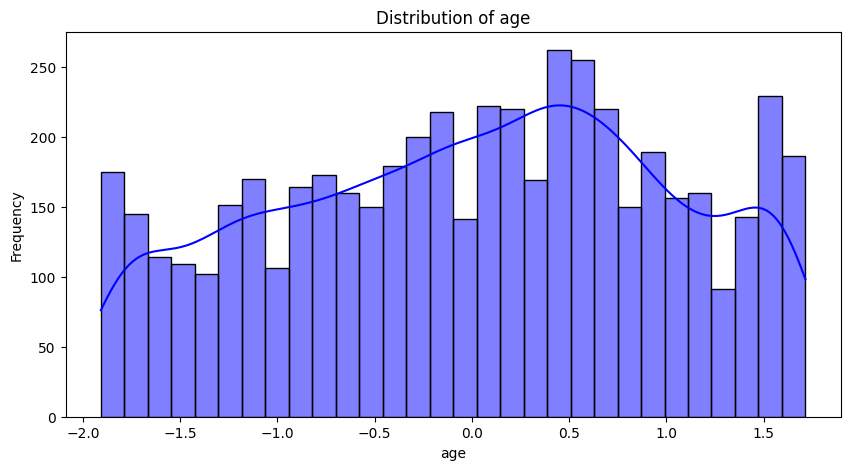

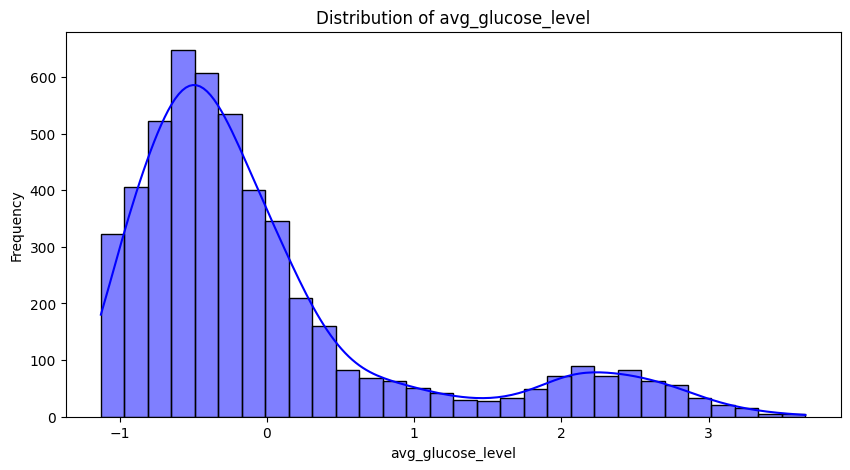

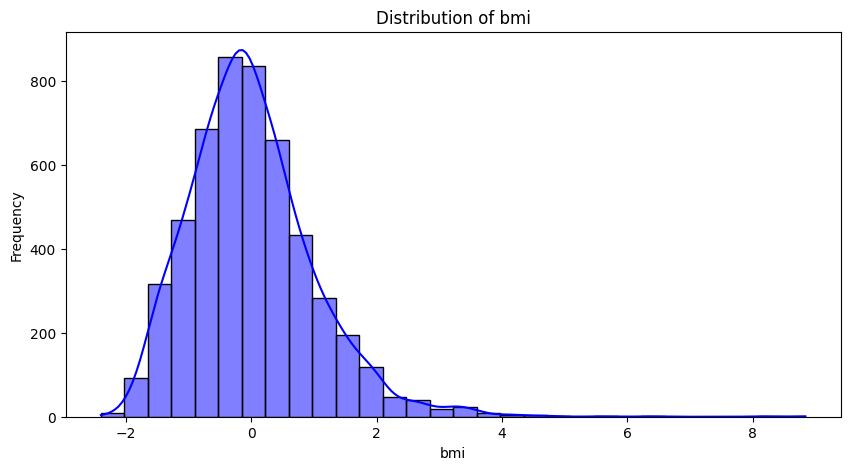

In [38]:
# Histogram
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [39]:
# power transformation for skewed features
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df[['avg_glucose_level', 'bmi']] = pt.fit_transform(df[['avg_glucose_level', 'bmi']])

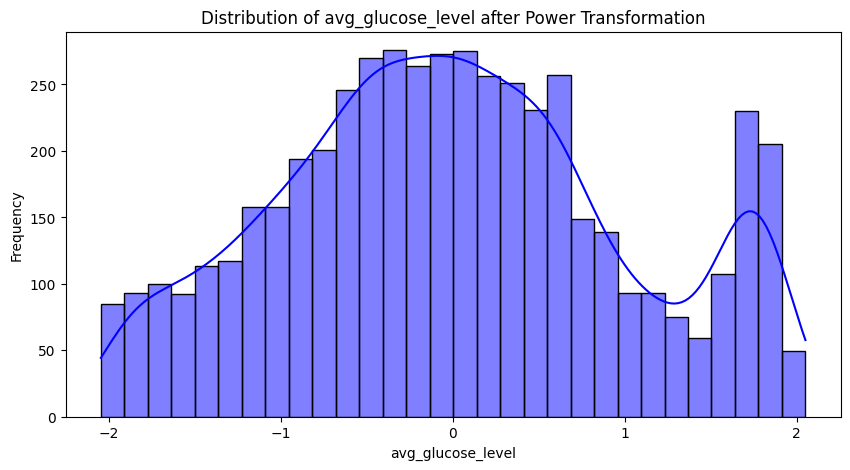

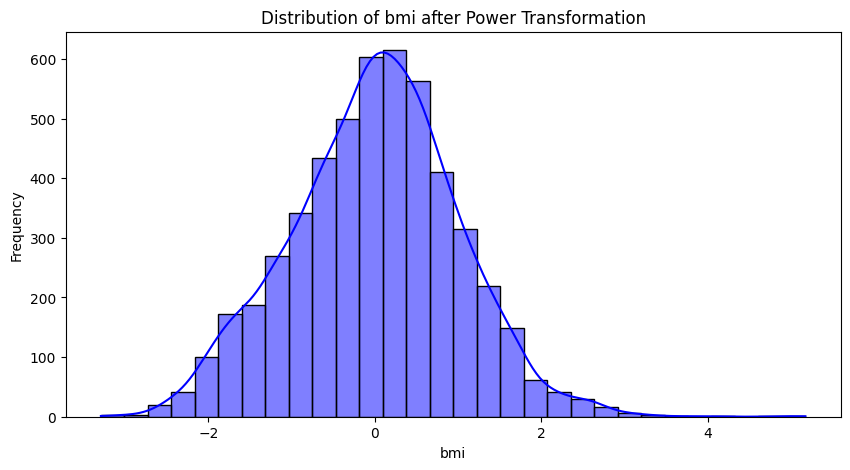

In [40]:
# check the distribution after power transformation
for col in ['avg_glucose_level', 'bmi']:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col} after Power Transformation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

`Outliers after Transformations`

In [41]:
numerical_df = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']]

outliers_iqr = pd.DataFrame(False, index=numerical_df.index, columns=numerical_df.columns)

for col in numerical_df:
    Q1, Q3 = np.percentile(numerical_df[col].dropna(), [25, 75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers_iqr[col] = (numerical_df[col] < lower) | (numerical_df[col] > upper)

print("Outliers per column (IQR):")
print(outliers_iqr.sum())
# ratio of outliers
print("Outlier ratio per column (IQR):")
print(outliers_iqr.mean())
# ratio from all
print("Overall outlier ratio (IQR):")
print(outliers_iqr.values.mean())

Outliers per column (IQR):
age                    0
hypertension         498
heart_disease        276
avg_glucose_level      0
bmi                   41
dtype: int64
Outlier ratio per column (IQR):
age                  0.000000
hypertension         0.097475
heart_disease        0.054022
avg_glucose_level    0.000000
bmi                  0.008025
dtype: float64
Overall outlier ratio (IQR):
0.031904482286161676


In [42]:
# z-score 
z_scores = zscore(numerical_df)
threshold = 3  # confidence is 99.7% (±3 standard deviations)
outliers_z = numerical_df[np.abs(z_scores) > threshold]
print("Z-score Outliers:")
print(outliers_z.sum())

Z-score Outliers:
age                    0.000000
hypertension         498.000000
heart_disease        276.000000
avg_glucose_level      0.000000
bmi                   33.625182
dtype: float64


- normalization using power transformation reduced no of outliers significantly
- now can remove extreme outliers as their percentage is small

`handle outliers`

In [43]:
# remove outliers with z-score
threshold = 3  # confidence is 99.7% (±3 standard deviations)

# compute z-scores for numeric columns
z_scores = np.abs(zscore(df[numerical_df.columns]))

# mask of rows to keep
mask = (z_scores <= threshold).all(axis=1)

# size before
size_before = df.shape[0]

# apply mask to the full dataframe (not just numerical_df)
df = df[mask].reset_index(drop=True)

# size after
size_after = df.shape[0]

print(f"Removed {size_before - size_after} outliers (Z-score)")
print(f"New size: {size_after}")


Removed 721 outliers (Z-score)
New size: 4388


In [44]:
# save to CSV
output_file_path = os.path.join(os.getcwd(), '..', 'data','processed_stroke_data.csv')
df.to_csv(output_file_path, index=False)

### `Final Df`
- Unnecessary dropped
- Encoded using label encoding
- Missing values imputed with KNN
- Scaled using StandardScaler
- Outliers handled using power transfotmation
- class imbalance -> later after spliting in modeling notebook
#### Ready for Logestic Regression or any other clf model

In [45]:
processed_df = pd.read_csv(output_file_path)
processed_df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.0,0.786070,0.0,0.0,1.0,3.0,0.0,1.686390,0.714684,2.0,1.0
1,0.0,0.255342,0.0,0.0,1.0,2.0,1.0,1.443331,0.795610,3.0,1.0
2,1.0,1.670617,0.0,0.0,1.0,2.0,1.0,1.570191,0.149957,1.0,1.0
3,0.0,1.139889,0.0,0.0,0.0,2.0,1.0,0.056750,-0.804200,2.0,1.0
4,0.0,0.697615,0.0,0.0,1.0,2.0,0.0,-0.754779,-0.073761,0.0,1.0
5,0.0,1.537935,0.0,0.0,1.0,2.0,1.0,-1.807753,-0.569352,0.0,1.0
6,0.0,0.476478,0.0,0.0,1.0,2.0,1.0,0.390228,-0.088310,3.0,1.0
7,0.0,0.741843,0.0,0.0,0.0,2.0,1.0,-0.145211,1.145575,2.0,1.0
8,0.0,1.228344,0.0,0.0,1.0,0.0,0.0,1.628497,-0.873160,3.0,1.0
9,0.0,1.582163,0.0,0.0,1.0,3.0,1.0,1.846766,-0.191926,2.0,1.0


In [46]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4388 entries, 0 to 4387
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4388 non-null   float64
 1   age                4388 non-null   float64
 2   hypertension       4388 non-null   float64
 3   heart_disease      4388 non-null   float64
 4   ever_married       4388 non-null   float64
 5   work_type          4388 non-null   float64
 6   residence_type     4388 non-null   float64
 7   avg_glucose_level  4388 non-null   float64
 8   bmi                4388 non-null   float64
 9   smoking_status     4388 non-null   float64
 10  stroke             4388 non-null   float64
dtypes: float64(11)
memory usage: 377.2 KB


`prepare data`

In [47]:
X = processed_df.drop(columns=['stroke'])
y = processed_df['stroke']

`data splitting`

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
# check the shape of the data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (3729, 10)
Testing data shape: (659, 10)


`handle class imbalance`

In [49]:
# oversample the minority class using SMOTE
sm = SMOTE(
    sampling_strategy=0.7,   # how much to oversample
    random_state=42,           
    k_neighbors=4,              # number of neighbors to generate new samples
)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# check shape after oversampling
print("Training data shape after oversampling:", X_train_res.shape)

Training data shape after oversampling: (6123, 10)


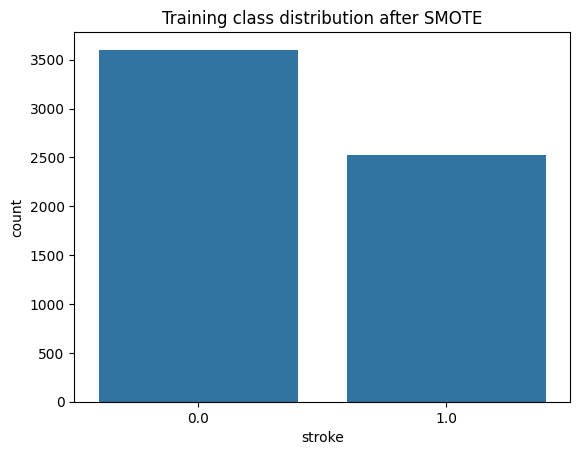

In [50]:
# visualize the class distribution
sns.countplot(x=y_train_res)
plt.title("Training class distribution after SMOTE")
plt.show()

`train`

In [51]:
# 1. Logistic Regression (default)
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,             # regularization strength (inverse)
    solver="lbfgs"     # you can change to "liblinear", "saga" etc.
)

log_reg.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data


LogisticRegression(max_iter=1000, random_state=42)

In [52]:
# 2. Logistic Regression (with class_weight balanced)
log_reg_balanced = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver="lbfgs",
    class_weight="balanced"
)

log_reg_balanced.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [53]:
# 3. Hard-Margin SVM (linear) -> C is very large (no slack variables)
svm_hard = SVC(
    kernel="linear",
    C=1e6,            # big C → hard margin
    random_state=42
)

svm_hard = LinearSVC(C=1e4, random_state=42, max_iter=10000)

svm_hard.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data

LinearSVC(C=10000.0, max_iter=10000, random_state=42)

In [54]:
# 4. Soft-Margin SVM (linear)
svm_soft = SVC(
    kernel="linear",
    C=1.0,            # regularization parameter
    random_state=42
)

svm_soft.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data

SVC(kernel='linear', random_state=42)

In [55]:
# 5. RBF Kernel SVM
svm_rbf = SVC(
    kernel="rbf",
    C=1.0,            # regularization
    gamma="scale",    # kernel coefficient ("scale", "auto" or float)
    random_state=42
)

svm_rbf.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data

SVC(random_state=42)

In [56]:
# 6. Polynomial Kernel SVM
svm_poly = SVC(
    kernel="poly",
    C=1.0,
    degree=5,         # degree of polynomial
    gamma="scale",    # kernel coefficient
    coef0=0.0,        # independent term
    random_state=42,
)

svm_poly.fit(X_train_res, y_train_res)  # train on SMOTE-resampled data

SVC(degree=5, kernel='poly', random_state=42)

`evalute`

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the models with parameters you can adjust
models = {
    "Logistic Regression": log_reg,
    "Logistic Regression (balanced)": log_reg_balanced,

    "SVM Hard-Margin (Linear)": svm_hard,
    
    "SVM Soft-Margin (Linear)": svm_soft,

    "SVM RBF Kernel": svm_rbf,
    "SVM Polynomial Kernel": svm_poly
}

# Loop through and evaluate each model
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)       # predict on test set

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0)
    }

# Show results
results_df = pd.DataFrame(results).T
print(results_df)

                                Accuracy  Precision    Recall  F1 Score
Logistic Regression             0.813354   0.096000  0.545455  0.163265
Logistic Regression (balanced)  0.751138   0.077381  0.590909  0.136842
SVM Hard-Margin (Linear)        0.802731   0.090909  0.545455  0.155844
SVM Soft-Margin (Linear)        0.790592   0.079710  0.500000  0.137500
SVM RBF Kernel                  0.799697   0.089552  0.545455  0.153846
SVM Polynomial Kernel           0.845220   0.083333  0.363636  0.135593


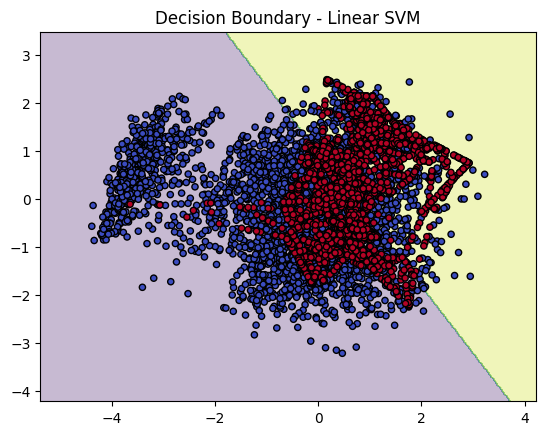

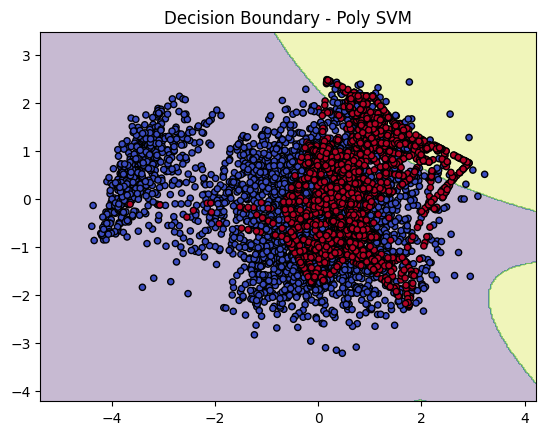

In [58]:
# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_res)  # use resampled training data
X_test_2D = pca.transform(X_test)

# Re-train two models on reduced features
svm_linear = SVC(kernel="linear", C=1.0, random_state=42)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)

svm_linear.fit(X_train_2D, y_train_res)
svm_poly.fit(X_train_2D, y_train_res)

models_2D = {"Linear SVM": svm_linear, "Poly SVM": svm_poly}

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.show()

# Plot for both models
for name, model in models_2D.items():
    plot_decision_boundary(model, X_train_2D, y_train_res, f"Decision Boundary - {name}")
